In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit,GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [2]:
#Load tabular data
Dataset=pd.read_csv(r'data/TabularSummaryBatteryData.csv')

# Scale target Battery life By log 10
Dataset['cell_life']=np.log10(Dataset['cell_life'])

numBat1=41
numBat2=43
numBat3=40
numBat=124
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
test_edited_ind = np.delete(test_ind, 21) # Remove battery 
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat)

Training_Data=Dataset.iloc[train_ind]
Testing_Data=Dataset.iloc[test_edited_ind]
Secondary_Data=Dataset.iloc[secondary_test_ind]

#choosing model features According to table 1
target_features=['cell_life']

varmod_features=['variance_dQ_100_10']

dismod_features=['minimum_dQ_100_10',
                 'variance_dQ_100_10',
                 'skewness_dQ_100_10',
                 'kurtosis_dQ_100_10',
                 'Discharge_Cap_2',
                 'Diff_MaxCap_DC2']
    
full_features=['minimum_dQ_100_10',
               'variance_dQ_100_10',
               'Slope_Cap_Fade_2_100',
               'Intercept_Cap_Fade_2_100',
               'Diff_MaxCap_DC2',
               'Discharge_Cap_2',
               'Avg_charge_time',
               'Temp_Integ_2_100',
               'Min_IR',
               'Diff_IR_2_100']

################################################################################

# Support Vector Regressor model

################################################################################

In [3]:
def SVRmodel(features,target,params):
    X_train=Training_Data[features].to_numpy()
    y_train=Training_Data[target].to_numpy()
    X_test=Testing_Data[features].to_numpy()
    y_test=Testing_Data[target].to_numpy()
    X_sec=Secondary_Data[features].to_numpy()
    y_sec=Secondary_Data[target].to_numpy()
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_sec = scaler.transform(X_sec)
    
##################

    model = SVR()
    grid=GridSearchCV(estimator=model,param_grid=params,cv=40)
    
#################

    grid.fit(X_train, y_train)
    print(grid.best_params_)
    
    y_pred_train=10**(grid.predict(X_train))
    y_pred_test=10**(grid.predict(X_test))
    y_pred_sec=10**(grid.predict(X_sec))
    
    y_train=10**(y_train)
    y_test=10**(y_test)
    y_sec=10**(y_sec)
    
    RMSE=list()
    MPE=list()
    
    RMSE.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    MPE.append(float(np.mean(np.abs((y_train - y_pred_train.reshape(-1,1))) / y_train * 100)))
    
    RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
    MPE.append(float(np.mean(np.abs((y_test - y_pred_test.reshape(-1,1))) / y_test * 100)))

    RMSE.append(np.sqrt(mean_squared_error(y_sec, y_pred_sec)))
    MPE.append(float(np.mean(np.abs((y_sec - y_pred_sec.reshape(-1,1))) / y_sec * 100)))

    plt.figure(figsize=(5,5)) 
    plt.xlabel('Observed Cycle Life')
    plt.ylabel('Predicted Cycle Life')
    plt.scatter(x=y_train,y=y_pred_train,marker='o',c='blue',s=100)
    plt.scatter(x=y_test,y=y_pred_test,marker='s',c='red',s=100)
    plt.scatter(x=y_sec,y=y_pred_sec,marker='^',c='orange',s=100)
    plt.xlim(0,2500)
    plt.ylim(0,2500)
    plt.plot(range(2500),c='black')
    plt.show()
    return np.round(RMSE,decimals=0),np.round(MPE,decimals=0)


# SVR Hyperparameters


In [4]:
SVR_dismod_hparams={'epsilon':[.01,0.1,1],
            'gamma':[.009,.001, 0.01, 0.1, 1, 10],
            'kernel':["sigmoid","linear","rbf"]}

SVR_full_hparams={'epsilon':[.01,0.1,1],
            'gamma':['scale',.009,.001, 0.01, 0.1, 1, 10],
            'kernel':["linear","rbf"]} # Sigmoid & Scale cause problems

################################################################################

# Multilayer perceptron model

################################################################################

In [5]:
def MLPmodel(features,target,params):
    X_train=Training_Data[features].to_numpy()
    y_train=Training_Data[target].to_numpy()
    X_test=Testing_Data[features].to_numpy()
    y_test=Testing_Data[target].to_numpy()
    X_sec=Secondary_Data[features].to_numpy()
    y_sec=Secondary_Data[target].to_numpy()
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_sec = scaler.transform(X_sec)
    
################## 

    model = MLPRegressor(random_state=0, max_iter=10000)
    grid = GridSearchCV(estimator=model, param_grid=params)
    
#################

    grid.fit(X_train, y_train)
    print(grid.best_params_)

    y_pred_train=10**(grid.predict(X_train))
    y_pred_test=10**(grid.predict(X_test))
    y_pred_sec=10**(grid.predict(X_sec))
    
    y_train=10**(y_train)
    y_test=10**(y_test)
    y_sec=10**(y_sec)
    
    RMSE=list()
    MPE=list()
    
    RMSE.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    MPE.append(float(np.mean(np.abs((y_train - y_pred_train.reshape(-1,1))) / y_train * 100)))
    
    RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
    MPE.append(float(np.mean(np.abs((y_test - y_pred_test.reshape(-1,1))) / y_test * 100)))

    RMSE.append(np.sqrt(mean_squared_error(y_sec, y_pred_sec)))
    MPE.append(float(np.mean(np.abs((y_sec - y_pred_sec.reshape(-1,1))) / y_sec * 100)))

    plt.figure(figsize=(5,5)) 
    plt.xlabel('Observed Cycle Life')
    plt.ylabel('Predicted Cycle Life')
    plt.scatter(x=y_train,y=y_pred_train,marker='o',c='blue',s=100)
    plt.scatter(x=y_test,y=y_pred_test,marker='s',c='red',s=100)
    plt.scatter(x=y_sec,y=y_pred_sec,marker='^',c='orange',s=100)
    plt.xlim(0,2500)
    plt.ylim(0,2500)
    plt.plot(range(2500),c='black')
    plt.show()
    return np.round(RMSE,decimals=0),np.round(MPE,decimals=0)

# MLP Hyperparameters

The hidden layer Sizes used for cross validation were chosen to match the Murphy's PML1 page 429, Neural Networks For Tabular data, Which references the following website by Brendan Hasz. As well as the shape of the MLP used for MNIST(Page 427). The size to was reduced match this data's Small feature set. 

https://brendanhasz.github.io/2019/07/23/bayesian-density-net.html

In [6]:
MLP_dismod_hparams={'hidden_layer_sizes':[[512,128,64,32],[784,128,128,10],[128,32,16],[256,128,64,32,16],
                                 [16, 32, 64, 128, 64, 32, 16],[16,32,64,32,16],[256, 64, 32, 16],[32,64,32,16]],
                    'alpha':[.001, 0.01, 0.1, 1, 10]}

MLP_full_hparams={'hidden_layer_sizes':[[512,128,64,32],[784,128,128,10],[128,32,16],[256,128,64,32,16],
                                 [16, 32, 64, 128, 64, 32, 16],[16,32,64,32,16],[256, 64, 32, 16],[32,64,32,16]],
                    'alpha':[.001, 0.01, 0.1, 1, 10]}



# Run both models


{'alpha': 1, 'hidden_layer_sizes': [32, 64, 32, 16]}


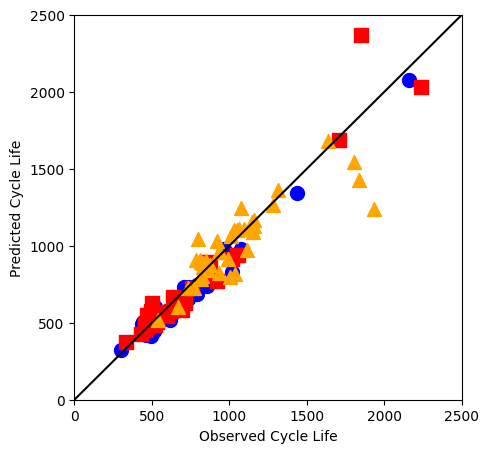

{'alpha': 0.1, 'hidden_layer_sizes': [16, 32, 64, 128, 64, 32, 16]}


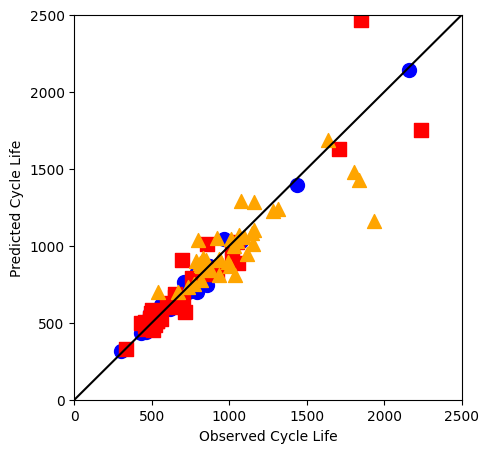

{'epsilon': 0.01, 'gamma': 0.009, 'kernel': 'sigmoid'}


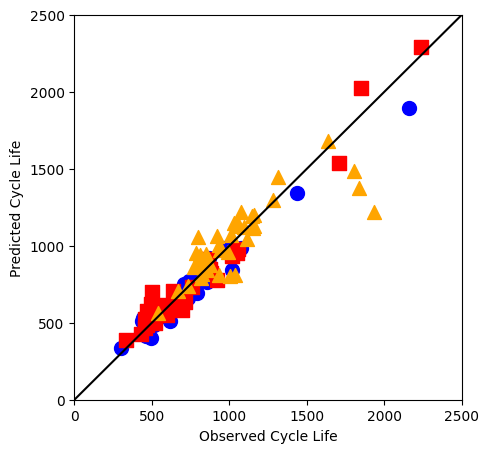

{'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear'}


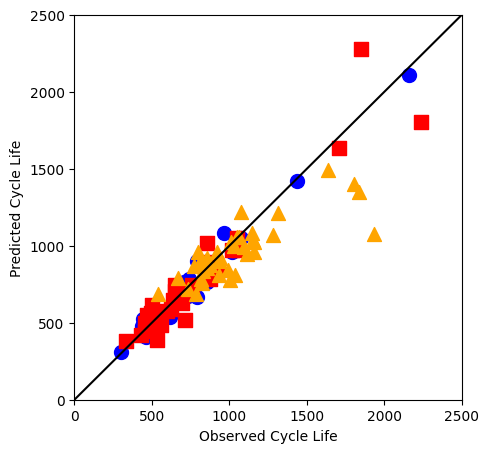

In [7]:
import warnings
warnings.filterwarnings('ignore')

dis_rmse,dis_mpe = MLPmodel(dismod_features,target_features,MLP_dismod_hparams)
full_rmse,full_mpe = MLPmodel(full_features,target_features,MLP_full_hparams)

SVRdis_rmse,SVRdis_mpe = SVRmodel(dismod_features,target_features,SVR_dismod_hparams)
SVRfull_rmse,SVRfull_mpe = SVRmodel(full_features,target_features,SVR_full_hparams)

In [8]:
pd.DataFrame({"Model":[ "MLP Discharge model", "MLP Full model","SVR Discharge model", "SVR Full model"],
      "RMSE - Train": [dis_rmse[0],full_rmse[0],SVRdis_rmse[0],SVRfull_rmse[0]],
      "RMSE - Test": [dis_rmse[1],full_rmse[1],SVRdis_rmse[1],SVRfull_rmse[1]],
      "RMSE - Secondary test": [dis_rmse[2],full_rmse[2],SVRdis_rmse[2],SVRfull_rmse[2]],
      "MPE - Train": [dis_mpe[0],full_mpe[0],SVRdis_mpe[0],SVRfull_mpe[0]],
      "MPE - Test": [dis_mpe[1],full_mpe[1],SVRdis_mpe[1],SVRfull_mpe[1]],
      "MPE - Secondary test": [dis_mpe[2],full_mpe[2],SVRdis_mpe[2],SVRfull_mpe[2]]})   

,Model,RMSE - Train,RMSE - Test,RMSE - Secondary test,MPE - Train,MPE - Test,MPE - Secondary test
0,MLP Discharge model,67.0,105.0,159.0,8.0,8.0,8.0
1,MLP Full model,39.0,138.0,176.0,4.0,8.0,10.0
2,SVR Discharge model,79.0,79.0,172.0,10.0,10.0,9.0
3,SVR Full model,54.0,115.0,200.0,7.0,9.0,11.0


################################################################################

# Repeat using only the first 60 cycles

################################################################################

In [9]:
#Load tabular data
Dataset=pd.read_csv(r'data/TabularSummaryBatteryData-60Cycles.csv')

# Scale target Battery life By log 10
Dataset['cell_life']=np.log10(Dataset['cell_life'])

Training_Data=Dataset.iloc[train_ind]
Testing_Data=Dataset.iloc[test_edited_ind]
Secondary_Data=Dataset.iloc[secondary_test_ind]

#choosing model features According to table 1
target_features=['cell_life']

varmod_features=['variance_dQ_60_10']

dismod_features=['minimum_dQ_60_10',
                 'variance_dQ_60_10',
                 'skewness_dQ_60_10',
                 'kurtosis_dQ_60_10',
                 'Discharge_Cap_2',
                 'Diff_MaxCap_DC2']
    
full_features=['minimum_dQ_60_10',
               'variance_dQ_60_10',
               'Slope_Cap_Fade_2_60',
               'Intercept_Cap_Fade_2_60',
               'Diff_MaxCap_DC2',
               'Discharge_Cap_2',
               'Avg_charge_time',
               'Temp_Integ_2_60',
               'Min_IR',
               'Diff_IR_2_60']


# Run both models - 60 cycles


{'alpha': 0.1, 'hidden_layer_sizes': [784, 128, 128, 10]}


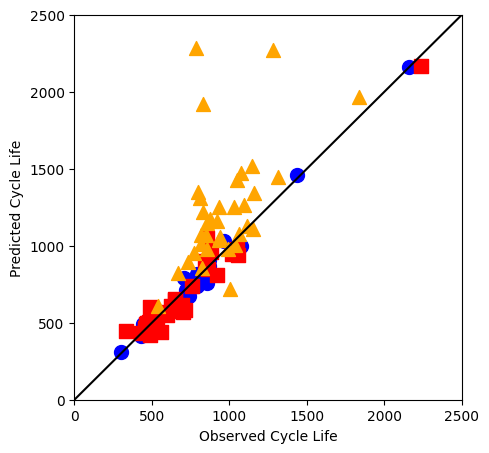

{'alpha': 0.1, 'hidden_layer_sizes': [16, 32, 64, 128, 64, 32, 16]}


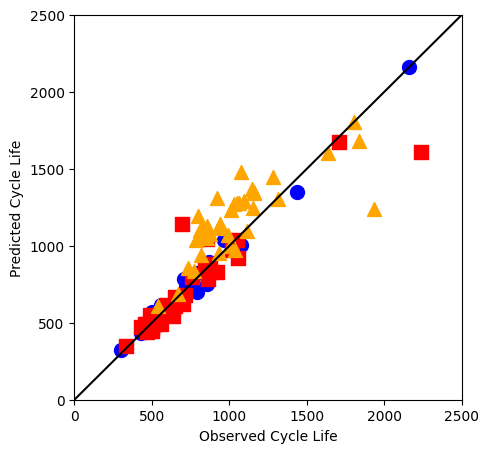

{'epsilon': 0.01, 'gamma': 0.009, 'kernel': 'sigmoid'}


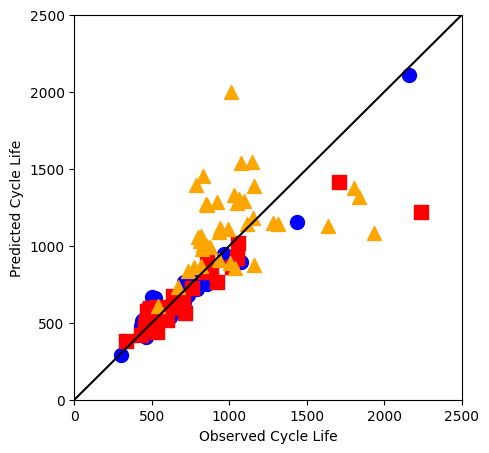

{'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear'}


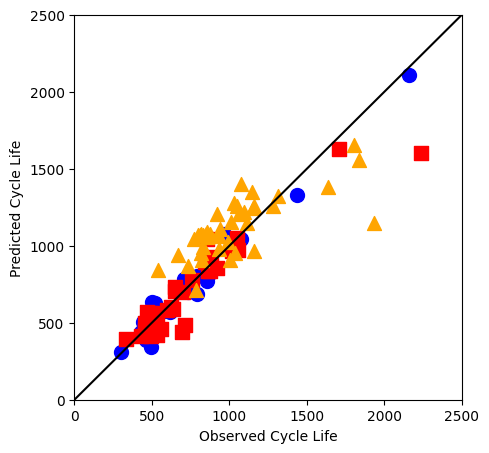

In [10]:
import warnings
warnings.filterwarnings('ignore')

dis_rmse,dis_mpe = MLPmodel(dismod_features,target_features,MLP_dismod_hparams)
full_rmse,full_mpe = MLPmodel(full_features,target_features,MLP_full_hparams)

SVRdis_rmse,SVRdis_mpe = SVRmodel(dismod_features,target_features,SVR_dismod_hparams)
SVRfull_rmse,SVRfull_mpe = SVRmodel(full_features,target_features,SVR_full_hparams)

In [11]:
pd.DataFrame({"Model":[ "MLP Discharge model", "MLP Full model","SVR Discharge model", "SVR Full model"],
      "RMSE - Train": [dis_rmse[0],full_rmse[0],SVRdis_rmse[0],SVRfull_rmse[0]],
      "RMSE - Test": [dis_rmse[1],full_rmse[1],SVRdis_rmse[1],SVRfull_rmse[1]],
      "RMSE - Secondary test": [dis_rmse[2],full_rmse[2],SVRdis_rmse[2],SVRfull_rmse[2]],
      "MPE - Train": [dis_mpe[0],full_mpe[0],SVRdis_mpe[0],SVRfull_mpe[0]],
      "MPE - Test": [dis_mpe[1],full_mpe[1],SVRdis_mpe[1],SVRfull_mpe[1]],
      "MPE - Secondary test": [dis_mpe[2],full_mpe[2],SVRdis_mpe[2],SVRfull_mpe[2]]})   

,Model,RMSE - Train,RMSE - Test,RMSE - Secondary test,MPE - Train,MPE - Test,MPE - Secondary test
0,MLP Discharge model,41.0,1931.0,2387.0,5.0,25.0,82.0
1,MLP Full model,41.0,402.0,232.0,5.0,11.0,19.0
2,SVR Discharge model,83.0,546.0,348.0,9.0,14.0,26.0
3,SVR Full model,58.0,243.0,227.0,7.0,11.0,19.0


################################################################################

# Repeat using only the first 40 cycles

################################################################################

In [12]:
#Load tabular data
Dataset=pd.read_csv(r'data/TabularSummaryBatteryData-40Cycles.csv')

# Scale target Battery life By log 10
Dataset['cell_life']=np.log10(Dataset['cell_life'])

Training_Data=Dataset.iloc[train_ind]
Testing_Data=Dataset.iloc[test_edited_ind]
Secondary_Data=Dataset.iloc[secondary_test_ind]

#choosing model features According to table 1
target_features=['cell_life']

varmod_features=['variance_dQ_40_10']

dismod_features=['minimum_dQ_40_10',
                 'variance_dQ_40_10',
                 'skewness_dQ_40_10',
                 'kurtosis_dQ_40_10',
                 'Discharge_Cap_2',
                 'Diff_MaxCap_DC2']
    
full_features=['minimum_dQ_40_10',
               'variance_dQ_40_10',
               'Slope_Cap_Fade_2_40',
               'Intercept_Cap_Fade_2_40',
               'Diff_MaxCap_DC2',
               'Discharge_Cap_2',
               'Avg_charge_time',
               'Temp_Integ_2_40',
               'Min_IR',
               'Diff_IR_2_40']



# Run both models - 40 cycles

{'alpha': 0.1, 'hidden_layer_sizes': [16, 32, 64, 128, 64, 32, 16]}


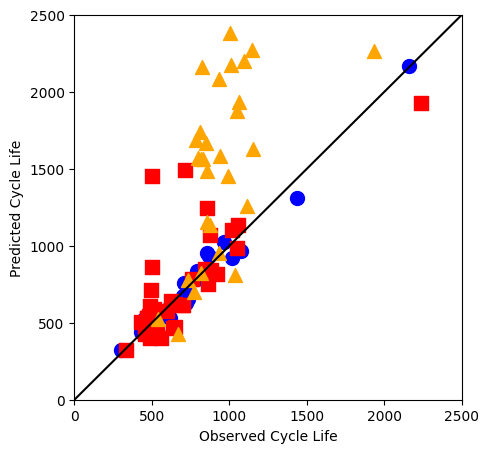

{'alpha': 0.1, 'hidden_layer_sizes': [16, 32, 64, 128, 64, 32, 16]}


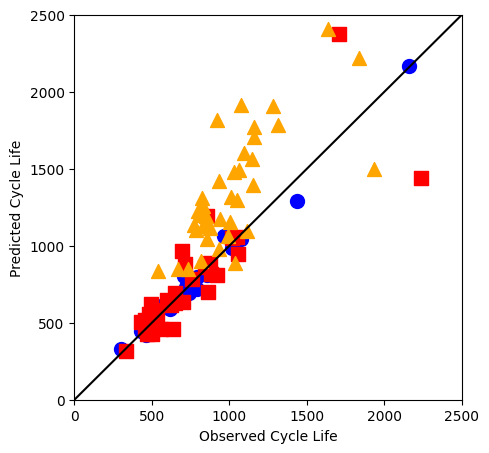

{'epsilon': 0.01, 'gamma': 0.009, 'kernel': 'sigmoid'}


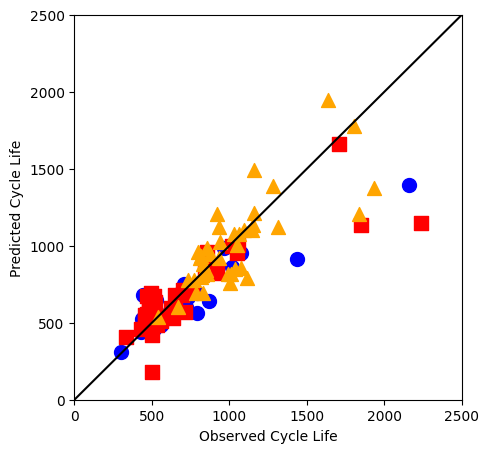

{'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear'}


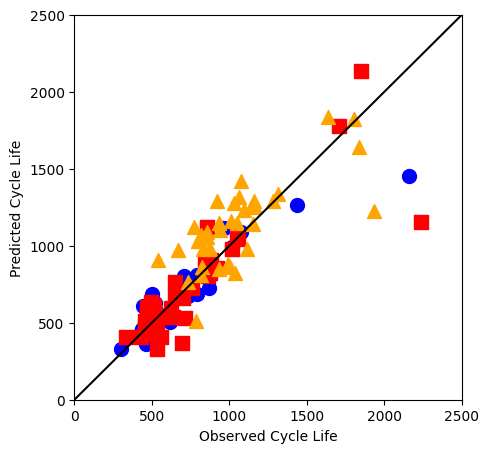

In [13]:
import warnings
warnings.filterwarnings('ignore')

dis_rmse,dis_mpe = MLPmodel(dismod_features,target_features,MLP_dismod_hparams)
full_rmse,full_mpe = MLPmodel(full_features,target_features,MLP_full_hparams)

SVRdis_rmse,SVRdis_mpe = SVRmodel(dismod_features,target_features,SVR_dismod_hparams)
SVRfull_rmse,SVRfull_mpe = SVRmodel(full_features,target_features,SVR_full_hparams)

In [14]:
pd.DataFrame({"Model":[ "MLP Discharge model", "MLP Full model","SVR Discharge model", "SVR Full model"],
      "RMSE - Train": [dis_rmse[0],full_rmse[0],SVRdis_rmse[0],SVRfull_rmse[0]],
      "RMSE - Primary test": [dis_rmse[1],full_rmse[1],SVRdis_rmse[1],SVRfull_rmse[1]],
      "RMSE - Secondary test": [dis_rmse[2],full_rmse[2],SVRdis_rmse[2],SVRfull_rmse[2]],
      "MPE - Train": [dis_mpe[0],full_mpe[0],SVRdis_mpe[0],SVRfull_mpe[0]],
      "MPE - Primary test": [dis_mpe[1],full_mpe[1],SVRdis_mpe[1],SVRfull_mpe[1]],
      "MPE - Secondary test": [dis_mpe[2],full_mpe[2],SVRdis_mpe[2],SVRfull_mpe[2]]})   

,Model,RMSE - Train,RMSE - Primary test,RMSE - Secondary test,MPE - Train,MPE - Primary test,MPE - Secondary test
0,MLP Discharge model,51.0,501.0,1345.0,6.0,26.0,98.0
1,MLP Full model,43.0,328.0,433.0,5.0,14.0,37.0
2,SVR Discharge model,172.0,225.0,195.0,14.0,16.0,12.0
3,SVR Full model,132.0,200.0,226.0,9.0,13.0,19.0


################################################################################

# Repeat using only the first 20 cycles

################################################################################

In [15]:
#Load tabular data
Dataset=pd.read_csv(r'data/TabularSummaryBatteryData-20Cycles.csv')

# Scale target Battery life By log 10
Dataset['cell_life']=np.log10(Dataset['cell_life'])

Training_Data=Dataset.iloc[train_ind]
Testing_Data=Dataset.iloc[test_edited_ind]
Secondary_Data=Dataset.iloc[secondary_test_ind]

#choosing model features According to table 1
target_features=['cell_life']

varmod_features=['variance_dQ_20_10']

dismod_features=['minimum_dQ_20_10',
                 'variance_dQ_20_10',
                 'skewness_dQ_20_10',
                 'kurtosis_dQ_20_10',
                 'Discharge_Cap_2',
                 'Diff_MaxCap_DC2']
    
full_features=['minimum_dQ_20_10',
               'variance_dQ_20_10',
               'Slope_Cap_Fade_2_20',
               'Intercept_Cap_Fade_2_20',
               'Diff_MaxCap_DC2',
               'Discharge_Cap_2',
               'Avg_charge_time',
               'Temp_Integ_2_20',
               'Min_IR',
               'Diff_IR_2_20']



# Run both models - 20 cycles

{'alpha': 10, 'hidden_layer_sizes': [128, 32, 16]}


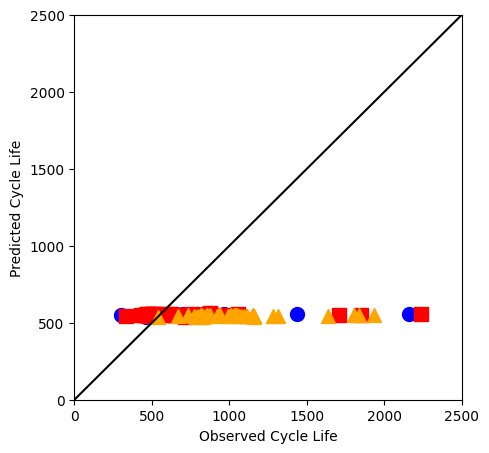

{'alpha': 0.1, 'hidden_layer_sizes': [16, 32, 64, 128, 64, 32, 16]}


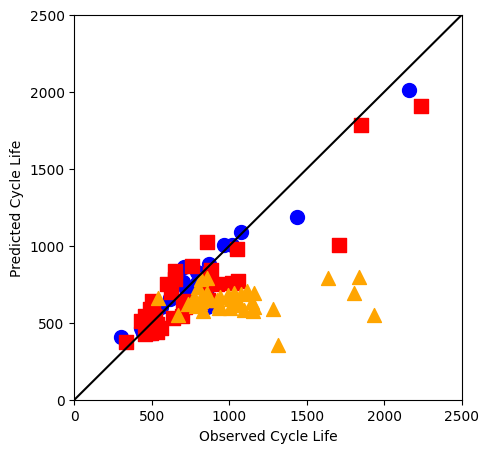

{'epsilon': 0.01, 'gamma': 0.009, 'kernel': 'sigmoid'}


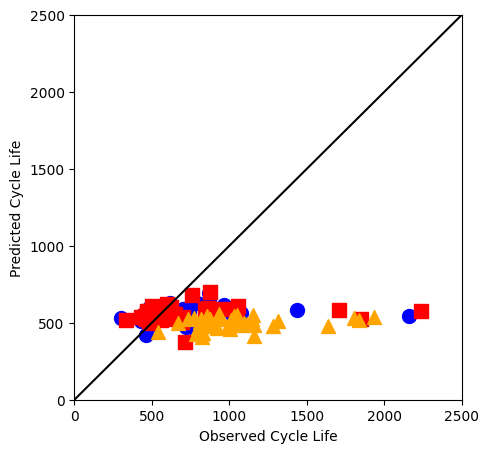

{'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear'}


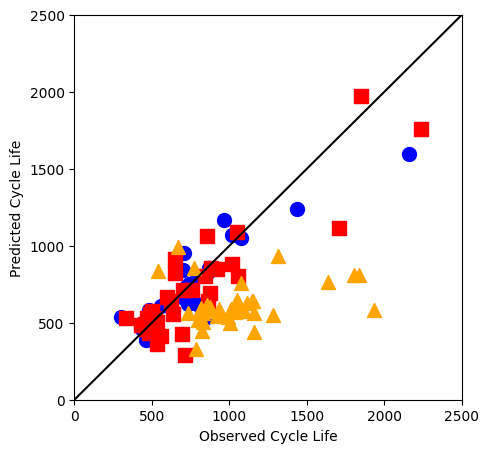

In [16]:
import warnings
warnings.filterwarnings('ignore')

dis_rmse,dis_mpe = MLPmodel(dismod_features,target_features,MLP_dismod_hparams)
full_rmse,full_mpe = MLPmodel(full_features,target_features,MLP_full_hparams)

SVRdis_rmse,SVRdis_mpe = SVRmodel(dismod_features,target_features,SVR_dismod_hparams)
SVRfull_rmse,SVRfull_mpe = SVRmodel(full_features,target_features,SVR_full_hparams)

In [17]:
pd.DataFrame({"Model":[ "MLP Discharge model", "MLP Full model","SVR Discharge model", "SVR Full model"],
      "RMSE - Train": [dis_rmse[0],full_rmse[0],SVRdis_rmse[0],SVRfull_rmse[0]],
      "RMSE - Test": [dis_rmse[1],full_rmse[1],SVRdis_rmse[1],SVRfull_rmse[1]],
      "RMSE - Secondary test": [dis_rmse[2],full_rmse[2],SVRdis_rmse[2],SVRfull_rmse[2]],
      "MPE - Train": [dis_mpe[0],full_mpe[0],SVRdis_mpe[0],SVRfull_mpe[0]],
      "MPE - Test": [dis_mpe[1],full_mpe[1],SVRdis_mpe[1],SVRfull_mpe[1]],
      "MPE - Secondary test": [dis_mpe[2],full_mpe[2],SVRdis_mpe[2],SVRfull_mpe[2]]})   

,Model,RMSE - Train,RMSE - Test,RMSE - Secondary test,MPE - Train,MPE - Test,MPE - Secondary test
0,MLP Discharge model,344.0,421.0,574.0,25.0,25.0,43.0
1,MLP Full model,78.0,162.0,496.0,8.0,14.0,34.0
2,SVR Discharge model,337.0,414.0,610.0,23.0,23.0,48.0
3,SVR Full model,132.0,176.0,513.0,10.0,15.0,41.0
